In [28]:
import optuna
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
import pandas            as pd

from sklearn.model_selection         import train_test_split
from sklearn.metrics                 import *
from sklearn.feature_extraction.text import TfidfVectorizer
from mlflow.models.signature         import infer_signature
from sklearn.linear_model            import LogisticRegression
from sklearn.svm                     import SVC
from xgboost                         import XGBClassifier
from lightgbm                        import LGBMClassifier
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.naive_bayes             import MultinomialNB
from sklearn.ensemble                import RandomForestClassifier
from sklearn.ensemble                import StackingClassifier
from imblearn.over_sampling          import SMOTE

In [2]:
df = pd.read_csv('preprocessed_corpus.csv')
df.head()

raw_comment  category  \
0   family mormon have never tried explain them t...         1   
1  buddhism has very much lot compatible with chr...         1   
2  seriously don say thing first all they won get...        -1   
3  what you have learned yours and only yours wha...         0   
4  for your own benefit you may want read living ...         1   

   word_count_raw  char_count_raw  num_unique_words  num_upper_words  \
0              39             261                34                0   
1             196            1269               136                0   
2              86             460                67                0   
3              29             168                24                0   
4             112             691                82                0   

   num_punctuation_raw                                    cleaned_comment  \
0                    0  family mormon have never tried explain them th...   
1                    0  buddhism has very much lot compatible with chr...   
2                    0  seriously don say thing first all they won get...   
3                    0  what you have learned yours and only yours wha...   
4                    0  for your own benefit you may want read living ...   

   num_stop_words                                  processed_comment  \
0              13  family mormon never tried explain still stare ...   
1              56  buddhism much lot compatible christianity espe...   
2              40  seriously say thing first get complex explain ...   
3              14  learned want teach different focus goal not wr...   
4              46  benefit may want read living buddha living chr...   

   final_word_count  final_char_count  
0                26               171  
1               140               842  
2                46               230  
3                15                87  
4                66               397

In [3]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-201-96-130.ap-south-1.compute.amazonaws.com:5000/")

In [16]:
# create an experiment 
mlflow.create_experiment(
                            name              = "Experiment_7_stacking",
                            artifact_location = "s3://mlflow-s3-25/Experiment_7_stacking"
                        )

'128394978459676117'

In [17]:
# set an experiment
mlflow.set_experiment("Experiment_7_stacking")

<Experiment: artifact_location='s3://mlflow-s3-25/Experiment_7_stacking', creation_time=1756998546214, experiment_id='128394978459676117', last_update_time=1756998546214, lifecycle_stage='active', name='Experiment_7_stacking', tags={}>

In [18]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category']       = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 4: Train-test split before vectorization and resampling
X_train, X_test, y_train, y_test = train_test_split(df['processed_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# Step 2: Vectorization using TF-IDF, fit on training data only
ngram_range          = (1, 3)                                    # Trigram setting
max_features         = 10000                                     # Set max_features to 1000 for TF-IDF

vectorizer           = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_vec          = vectorizer.fit_transform(X_train)          # Fit on training data
X_test_vec           = vectorizer.transform    (X_test)           # Transform test data

smote                = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [19]:
# Step 5: Optuna objective for LightGBM
def objective_lightgbm(trial):
    params = {
                  "n_estimators"      : trial.suggest_int  ("n_estimators",      100, 1000),
                  "learning_rate"     : trial.suggest_float("learning_rate",     1e-4, 1e-1, log=True),
                  "max_depth"         : trial.suggest_int  ("max_depth",         3, 15),
                  "num_leaves"        : trial.suggest_int  ("num_leaves",        20, 150),
                  "min_child_samples" : trial.suggest_int  ("min_child_samples", 10, 100),
                  "colsample_bytree"  : trial.suggest_float("colsample_bytree",  0.5, 1.0),
                  "subsample"         : trial.suggest_float("subsample",         0.5, 1.0),
                  "reg_alpha"         : trial.suggest_float("reg_alpha",         1e-4, 10.0, log=True),
                  "reg_lambda"        : trial.suggest_float("reg_lambda",        1e-4, 10.0, log=True),
                  "random_state"      : 42
            }
    
    model = LGBMClassifier(**params)
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    return accuracy_score(y_test, preds)

In [20]:
# Step 6: Run Optuna
study     = optuna.create_study(direction="maximize")
study.optimize(objective_lightgbm, n_trials=50)

[I 2025-09-04 20:39:15,025] A new study created in memory with name: no-name-0a6ea42c-4803-42ca-9ae5-53ac13653b0c


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101771
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 962
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:39:33,215] Trial 0 finished with value: 0.767467248908297 and parameters: {'n_estimators': 801, 'learning_rate': 0.04898661460782946, 'max_depth': 10, 'num_leaves': 91, 'min_child_samples': 89, 'colsample_bytree': 0.5637693086337252, 'subsample': 0.9586508105427387, 'reg_alpha': 0.006826485905790263, 'reg_lambda': 0.2940553878367573}. Best is trial 0 with value: 0.767467248908297.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102192
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 992
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:40:05,282] Trial 1 finished with value: 0.7105622270742358 and parameters: {'n_estimators': 508, 'learning_rate': 0.005410437054809039, 'max_depth': 12, 'num_leaves': 73, 'min_child_samples': 11, 'colsample_bytree': 0.7561691592632562, 'subsample': 0.8303763725290807, 'reg_alpha': 0.6732724751341004, 'reg_lambda': 0.007919060254365149}. Best is trial 0 with value: 0.767467248908297.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101771
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 962
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:40:15,664] Trial 2 finished with value: 0.7700600436681223 and parameters: {'n_estimators': 803, 'learning_rate': 0.07248853047356213, 'max_depth': 5, 'num_leaves': 105, 'min_child_samples': 89, 'colsample_bytree': 0.7788120241553862, 'subsample': 0.8549199557963376, 'reg_alpha': 0.0030039825641445497, 'reg_lambda': 0.044874854790684204}. Best is trial 2 with value: 0.7700600436681223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:40:36,915] Trial 3 finished with value: 0.6844978165938864 and parameters: {'n_estimators': 675, 'learning_rate': 0.0015515070588799672, 'max_depth': 11, 'num_leaves': 35, 'min_child_samples': 30, 'colsample_bytree': 0.5220641066246716, 'subsample': 0.6777714792721572, 'reg_alpha': 0.0002055084994314861, 'reg_lambda': 0.042200814906396905}. Best is trial 2 with value: 0.7700600436681223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:40:43,320] Trial 4 finished with value: 0.6543395196506551 and parameters: {'n_estimators': 188, 'learning_rate': 0.00734339438123805, 'max_depth': 8, 'num_leaves': 36, 'min_child_samples': 56, 'colsample_bytree': 0.8079609951952929, 'subsample': 0.8202770195559753, 'reg_alpha': 0.0559343088760913, 'reg_lambda': 0.0015287532141229152}. Best is trial 2 with value: 0.7700600436681223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102043
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 973
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:41:09,801] Trial 5 finished with value: 0.6359170305676856 and parameters: {'n_estimators': 975, 'learning_rate': 0.0002806366671567049, 'max_depth': 9, 'num_leaves': 66, 'min_child_samples': 60, 'colsample_bytree': 0.7561200304011189, 'subsample': 0.6533886019868642, 'reg_alpha': 1.363003916668696, 'reg_lambda': 9.806450240359657}. Best is trial 2 with value: 0.7700600436681223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:41:26,799] Trial 6 finished with value: 0.6460152838427947 and parameters: {'n_estimators': 417, 'learning_rate': 0.0013345542897295962, 'max_depth': 10, 'num_leaves': 55, 'min_child_samples': 49, 'colsample_bytree': 0.8067710884315998, 'subsample': 0.5729177481005475, 'reg_alpha': 0.9831776790608564, 'reg_lambda': 0.18714539266583888}. Best is trial 2 with value: 0.7700600436681223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:41:40,832] Trial 7 finished with value: 0.7730622270742358 and parameters: {'n_estimators': 342, 'learning_rate': 0.07078546435396003, 'max_depth': 13, 'num_leaves': 141, 'min_child_samples': 40, 'colsample_bytree': 0.8785843276853246, 'subsample': 0.8829079149001846, 'reg_alpha': 0.10254909662745144, 'reg_lambda': 0.3603089245240148}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101861
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 965
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:41:45,830] Trial 8 finished with value: 0.6891375545851528 and parameters: {'n_estimators': 363, 'learning_rate': 0.015560465284844833, 'max_depth': 4, 'num_leaves': 71, 'min_child_samples': 78, 'colsample_bytree': 0.9323157303986753, 'subsample': 0.7877955721545373, 'reg_alpha': 0.03294330839136559, 'reg_lambda': 0.002050814469529845}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102184
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 990
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:41:49,451] Trial 9 finished with value: 0.5764192139737991 and parameters: {'n_estimators': 144, 'learning_rate': 0.0043199215164456675, 'max_depth': 5, 'num_leaves': 124, 'min_child_samples': 12, 'colsample_bytree': 0.9121259142746914, 'subsample': 0.5028235143899127, 'reg_alpha': 0.00021242077138222096, 'reg_lambda': 0.5867176809076767}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:42:05,435] Trial 10 finished with value: 0.675764192139738 and parameters: {'n_estimators': 298, 'learning_rate': 0.00022283900148167927, 'max_depth': 14, 'num_leaves': 148, 'min_child_samples': 35, 'colsample_bytree': 0.6420753411703252, 'subsample': 0.990045290473604, 'reg_alpha': 0.3434795946498203, 'reg_lambda': 2.155398167029155}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101611
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 957
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:42:25,839] Trial 11 finished with value: 0.7677401746724891 and parameters: {'n_estimators': 688, 'learning_rate': 0.09493168279770253, 'max_depth': 15, 'num_leaves': 107, 'min_child_samples': 99, 'colsample_bytree': 0.9832958596823487, 'subsample': 0.8960636202042744, 'reg_alpha': 0.003026867565241093, 'reg_lambda': 0.00015402789350193078}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101861
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 965
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:42:43,344] Trial 12 finished with value: 0.7650109170305677 and parameters: {'n_estimators': 961, 'learning_rate': 0.02339537121354759, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 72, 'colsample_bytree': 0.8685582591475604, 'subsample': 0.8966064888203193, 'reg_alpha': 0.0030009881164558562, 'reg_lambda': 0.04483771342861791}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:42:48,929] Trial 13 finished with value: 0.7718340611353712 and parameters: {'n_estimators': 596, 'learning_rate': 0.09332946641647755, 'max_depth': 3, 'num_leaves': 118, 'min_child_samples': 33, 'colsample_bytree': 0.6674866584006085, 'subsample': 0.7371046643467755, 'reg_alpha': 0.10315469499349068, 'reg_lambda': 0.012291821652260428}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:42:54,266] Trial 14 finished with value: 0.7236626637554585 and parameters: {'n_estimators': 535, 'learning_rate': 0.024962187446025307, 'max_depth': 3, 'num_leaves': 128, 'min_child_samples': 33, 'colsample_bytree': 0.6632966552051358, 'subsample': 0.710006845475099, 'reg_alpha': 0.16538401845927397, 'reg_lambda': 0.006368492069378132}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:43:03,502] Trial 15 finished with value: 0.761599344978166 and parameters: {'n_estimators': 303, 'learning_rate': 0.04168723696805437, 'max_depth': 13, 'num_leaves': 122, 'min_child_samples': 44, 'colsample_bytree': 0.6674051173550425, 'subsample': 0.7504305764725684, 'reg_alpha': 6.242234002746428, 'reg_lambda': 1.0684136231767658}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102114
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 979
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:43:21,869] Trial 16 finished with value: 0.7371724890829694 and parameters: {'n_estimators': 629, 'learning_rate': 0.012483277402622162, 'max_depth': 7, 'num_leaves': 99, 'min_child_samples': 23, 'colsample_bytree': 0.8584801891135815, 'subsample': 0.7435173566611226, 'reg_alpha': 0.11829663093430225, 'reg_lambda': 0.00023922277133422065}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:43:57,356] Trial 17 finished with value: 0.6959606986899564 and parameters: {'n_estimators': 480, 'learning_rate': 0.0016753907340010302, 'max_depth': 15, 'num_leaves': 135, 'min_child_samples': 43, 'colsample_bytree': 0.6023704112393719, 'subsample': 0.6268076596494297, 'reg_alpha': 0.012918907807729002, 'reg_lambda': 0.13471602610404837}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101931
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 968
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:44:05,514] Trial 18 finished with value: 0.6612991266375546 and parameters: {'n_estimators': 251, 'learning_rate': 0.0006582969250790621, 'max_depth': 12, 'num_leaves': 113, 'min_child_samples': 65, 'colsample_bytree': 0.698244050019662, 'subsample': 0.9220224401365755, 'reg_alpha': 4.904289134281221, 'reg_lambda': 0.01390581145502128}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102114
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 979
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:44:09,870] Trial 19 finished with value: 0.7665120087336245 and parameters: {'n_estimators': 437, 'learning_rate': 0.09794541753196803, 'max_depth': 3, 'num_leaves': 145, 'min_child_samples': 24, 'colsample_bytree': 0.7079974912925757, 'subsample': 0.7744205074656038, 'reg_alpha': 0.0008310357190191475, 'reg_lambda': 0.00118095876000464}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:44:23,569] Trial 20 finished with value: 0.7671943231441049 and parameters: {'n_estimators': 607, 'learning_rate': 0.038126185553423224, 'max_depth': 8, 'num_leaves': 116, 'min_child_samples': 48, 'colsample_bytree': 0.994206441521708, 'subsample': 0.5978440084188765, 'reg_alpha': 0.016492424482021286, 'reg_lambda': 3.406603791822328}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101861
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 965
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:44:34,298] Trial 21 finished with value: 0.7707423580786026 and parameters: {'n_estimators': 821, 'learning_rate': 0.06705270273962449, 'max_depth': 5, 'num_leaves': 103, 'min_child_samples': 83, 'colsample_bytree': 0.8372950041005053, 'subsample': 0.8497241538855945, 'reg_alpha': 0.058694710933231364, 'reg_lambda': 0.08468932185005956}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:44:45,489] Trial 22 finished with value: 0.7730622270742358 and parameters: {'n_estimators': 774, 'learning_rate': 0.05170417615777296, 'max_depth': 5, 'num_leaves': 87, 'min_child_samples': 39, 'colsample_bytree': 0.8524025400664192, 'subsample': 0.8451279752824621, 'reg_alpha': 0.1157483425146901, 'reg_lambda': 0.08330246498225374}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:44:53,126] Trial 23 finished with value: 0.736353711790393 and parameters: {'n_estimators': 724, 'learning_rate': 0.02465682488649943, 'max_depth': 3, 'num_leaves': 87, 'min_child_samples': 38, 'colsample_bytree': 0.9030592571624213, 'subsample': 0.7978657594195615, 'reg_alpha': 0.19918451819863167, 'reg_lambda': 0.019627780265956827}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102114
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 979
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:45:05,491] Trial 24 finished with value: 0.7262554585152838 and parameters: {'n_estimators': 589, 'learning_rate': 0.014315245958285188, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 22, 'colsample_bytree': 0.9425010915696082, 'subsample': 0.8903559120261961, 'reg_alpha': 2.515840911353252, 'reg_lambda': 0.4134485775124825}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:45:15,197] Trial 25 finished with value: 0.7680131004366813 and parameters: {'n_estimators': 869, 'learning_rate': 0.04103683001622204, 'max_depth': 4, 'num_leaves': 56, 'min_child_samples': 51, 'colsample_bytree': 0.716301516315674, 'subsample': 0.7146771666006118, 'reg_alpha': 0.3905153288198225, 'reg_lambda': 0.0033173821390431123}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:45:35,007] Trial 26 finished with value: 0.7235262008733624 and parameters: {'n_estimators': 712, 'learning_rate': 0.008750971715026958, 'max_depth': 7, 'num_leaves': 79, 'min_child_samples': 40, 'colsample_bytree': 0.8819585823428611, 'subsample': 0.9346437151284843, 'reg_alpha': 0.07916094415317333, 'reg_lambda': 0.0887214390544448}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102105
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 978
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:45:40,067] Trial 27 finished with value: 0.7547762008733624 and parameters: {'n_estimators': 394, 'learning_rate': 0.05401741074857514, 'max_depth': 4, 'num_leaves': 140, 'min_child_samples': 28, 'colsample_bytree': 0.8167671019490728, 'subsample': 0.8690053951793731, 'reg_alpha': 0.03162715523987147, 'reg_lambda': 0.9584623970326182}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102136
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 982
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:46:18,178] Trial 28 finished with value: 0.7726528384279476 and parameters: {'n_estimators': 878, 'learning_rate': 0.025612496971746248, 'max_depth': 13, 'num_leaves': 95, 'min_child_samples': 18, 'colsample_bytree': 0.6230409670305818, 'subsample': 0.9998419193298408, 'reg_alpha': 0.2994109214204671, 'reg_lambda': 0.0007370577311931178}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102150
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 984
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:46:52,167] Trial 29 finished with value: 0.7727893013100436 and parameters: {'n_estimators': 927, 'learning_rate': 0.028886265981186657, 'max_depth': 13, 'num_leaves': 95, 'min_child_samples': 17, 'colsample_bytree': 0.5677063837123526, 'subsample': 0.9976128347118622, 'reg_alpha': 0.35564205710082514, 'reg_lambda': 0.000580649395287545}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102021
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 972
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:47:27,935] Trial 30 finished with value: 0.7023744541484717 and parameters: {'n_estimators': 916, 'learning_rate': 0.0025195423694444534, 'max_depth': 11, 'num_leaves': 88, 'min_child_samples': 64, 'colsample_bytree': 0.5293442298142776, 'subsample': 0.9612428152398522, 'reg_alpha': 0.008814621992164703, 'reg_lambda': 0.000665266331576243}. Best is trial 7 with value: 0.7730622270742358.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102179
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 989
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:48:00,723] Trial 31 finished with value: 0.775245633187773 and parameters: {'n_estimators': 869, 'learning_rate': 0.03414197439731844, 'max_depth': 13, 'num_leaves': 95, 'min_child_samples': 13, 'colsample_bytree': 0.5791819866249326, 'subsample': 0.9929958694934502, 'reg_alpha': 0.41062716630651414, 'reg_lambda': 0.0003457816633413684}. Best is trial 31 with value: 0.775245633187773.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102156
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 985
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:48:29,365] Trial 32 finished with value: 0.7757914847161572 and parameters: {'n_estimators': 781, 'learning_rate': 0.03525301214468787, 'max_depth': 13, 'num_leaves': 79, 'min_child_samples': 16, 'colsample_bytree': 0.5825354739318194, 'subsample': 0.959486645283152, 'reg_alpha': 0.6327839585986061, 'reg_lambda': 0.0005069896395758743}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102196
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 993
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:48:58,353] Trial 33 finished with value: 0.7748362445414847 and parameters: {'n_estimators': 775, 'learning_rate': 0.05589007473676604, 'max_depth': 14, 'num_leaves': 82, 'min_child_samples': 10, 'colsample_bytree': 0.5741569180207484, 'subsample': 0.9464191626374913, 'reg_alpha': 1.7135043653878756, 'reg_lambda': 0.000271787457546172}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102196
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 993
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:49:26,125] Trial 34 finished with value: 0.7756550218340611 and parameters: {'n_estimators': 769, 'learning_rate': 0.0562132836720807, 'max_depth': 14, 'num_leaves': 62, 'min_child_samples': 10, 'colsample_bytree': 0.5653425301845599, 'subsample': 0.9606447695620972, 'reg_alpha': 2.0652396540148446, 'reg_lambda': 0.0003152428236875644}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102196
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 993
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:50:02,262] Trial 35 finished with value: 0.6859989082969432 and parameters: {'n_estimators': 779, 'learning_rate': 0.00012068314804205645, 'max_depth': 14, 'num_leaves': 58, 'min_child_samples': 10, 'colsample_bytree': 0.5628915471873276, 'subsample': 0.9596733380072074, 'reg_alpha': 1.8510623524761085, 'reg_lambda': 0.0001384360535840629}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102162
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 986
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:50:29,678] Trial 36 finished with value: 0.7504093886462883 and parameters: {'n_estimators': 842, 'learning_rate': 0.008736411556736216, 'max_depth': 14, 'num_leaves': 42, 'min_child_samples': 15, 'colsample_bytree': 0.5106349623488682, 'subsample': 0.9308041575946686, 'reg_alpha': 9.437113143060932, 'reg_lambda': 0.0002271921537548343}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102196
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 993
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:50:57,133] Trial 37 finished with value: 0.775382096069869 and parameters: {'n_estimators': 745, 'learning_rate': 0.03636580914161926, 'max_depth': 12, 'num_leaves': 78, 'min_child_samples': 10, 'colsample_bytree': 0.5864683659337208, 'subsample': 0.9684965032540158, 'reg_alpha': 0.7404475150760792, 'reg_lambda': 0.0003233198522605952}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102136
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 982
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:51:18,864] Trial 38 finished with value: 0.767603711790393 and parameters: {'n_estimators': 665, 'learning_rate': 0.018629803051265232, 'max_depth': 11, 'num_leaves': 64, 'min_child_samples': 19, 'colsample_bytree': 0.5399975816186503, 'subsample': 0.9678871964491546, 'reg_alpha': 0.7349525758805252, 'reg_lambda': 0.00041678123746465836}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102105
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 978
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:51:43,917] Trial 39 finished with value: 0.7520469432314411 and parameters: {'n_estimators': 733, 'learning_rate': 0.010456853754214275, 'max_depth': 12, 'num_leaves': 44, 'min_child_samples': 28, 'colsample_bytree': 0.6025269571949412, 'subsample': 0.9210453012672344, 'reg_alpha': 3.1324746802454264, 'reg_lambda': 0.00347406284895875}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102162
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 986
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:52:26,691] Trial 40 finished with value: 0.7311681222707423 and parameters: {'n_estimators': 992, 'learning_rate': 0.00498445241056148, 'max_depth': 10, 'num_leaves': 77, 'min_child_samples': 14, 'colsample_bytree': 0.5970999025144393, 'subsample': 0.9770246434832269, 'reg_alpha': 0.7895792193677078, 'reg_lambda': 0.0001025956398781156}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102192
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 992
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:52:56,651] Trial 41 finished with value: 0.775382096069869 and parameters: {'n_estimators': 773, 'learning_rate': 0.03390028466787586, 'max_depth': 14, 'num_leaves': 81, 'min_child_samples': 11, 'colsample_bytree': 0.5664847513277079, 'subsample': 0.9453861856678806, 'reg_alpha': 1.7203629222404804, 'reg_lambda': 0.00030922150858342953}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102114
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 979
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:53:24,456] Trial 42 finished with value: 0.7742903930131004 and parameters: {'n_estimators': 817, 'learning_rate': 0.03625310957992379, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 21, 'colsample_bytree': 0.5465582994232986, 'subsample': 0.9186657737704149, 'reg_alpha': 0.9640501354843058, 'reg_lambda': 0.0011462264256686546}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102162
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 986
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:53:58,107] Trial 43 finished with value: 0.7719705240174672 and parameters: {'n_estimators': 896, 'learning_rate': 0.018907406248099556, 'max_depth': 12, 'num_leaves': 62, 'min_child_samples': 14, 'colsample_bytree': 0.633013542763065, 'subsample': 0.9726551232430707, 'reg_alpha': 3.6773070738948084, 'reg_lambda': 0.00028898380139475837}. Best is trial 32 with value: 0.7757914847161572.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102105
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 978
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:54:18,194] Trial 44 finished with value: 0.7768831877729258 and parameters: {'n_estimators': 653, 'learning_rate': 0.034542103746940105, 'max_depth': 13, 'num_leaves': 74, 'min_child_samples': 26, 'colsample_bytree': 0.5015386040287596, 'subsample': 0.9493493750835515, 'reg_alpha': 0.5563181398692472, 'reg_lambda': 0.002248186484798954}. Best is trial 44 with value: 0.7768831877729258.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102105
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 978
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:54:34,888] Trial 45 finished with value: 0.7741539301310044 and parameters: {'n_estimators': 657, 'learning_rate': 0.06195348332622149, 'max_depth': 12, 'num_leaves': 51, 'min_child_samples': 26, 'colsample_bytree': 0.5015622060447524, 'subsample': 0.9047018422081119, 'reg_alpha': 1.3310248362093526, 'reg_lambda': 0.0020203558718874617}. Best is trial 44 with value: 0.7768831877729258.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102136
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 982
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:54:55,738] Trial 46 finished with value: 0.773471615720524 and parameters: {'n_estimators': 746, 'learning_rate': 0.016730359723759254, 'max_depth': 14, 'num_leaves': 27, 'min_child_samples': 18, 'colsample_bytree': 0.5496303722626116, 'subsample': 0.9509478679354435, 'reg_alpha': 0.5298937591266493, 'reg_lambda': 0.0009411912869321731}. Best is trial 44 with value: 0.7768831877729258.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102063
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 974
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:55:15,486] Trial 47 finished with value: 0.7727893013100436 and parameters: {'n_estimators': 679, 'learning_rate': 0.06878822967990017, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 31, 'colsample_bytree': 0.5209211255376721, 'subsample': 0.8651178950166128, 'reg_alpha': 1.2553561516745249, 'reg_lambda': 0.0005189950955196369}. Best is trial 44 with value: 0.7768831877729258.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102196
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 993
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:55:42,694] Trial 48 finished with value: 0.7158842794759825 and parameters: {'n_estimators': 559, 'learning_rate': 0.006894607828309861, 'max_depth': 11, 'num_leaves': 79, 'min_child_samples': 10, 'colsample_bytree': 0.6220076137488554, 'subsample': 0.8204948198312071, 'reg_alpha': 7.043669406402301, 'reg_lambda': 0.0038628582248232592}. Best is trial 44 with value: 0.7768831877729258.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102114
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 979
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-04 20:56:14,733] Trial 49 finished with value: 0.6795851528384279 and parameters: {'n_estimators': 766, 'learning_rate': 0.0005805600809627526, 'max_depth': 13, 'num_leaves': 51, 'min_child_samples': 21, 'colsample_bytree': 0.5842685093015871, 'subsample': 0.9441616341209472, 'reg_alpha': 2.451940257757149, 'reg_lambda': 0.0001612982480384844}. Best is trial 44 with value: 0.7768831877729258.


In [21]:
# Step 7: Build base models
lightgbm_model = LGBMClassifier       (**study.best_params, random_state=42)
logreg_model   = LogisticRegression   (max_iter=1000, random_state=42)
knn_meta       = KNeighborsClassifier (n_neighbors=5)

In [30]:
# Step 8: Build stacking model
stacking_model = StackingClassifier(
                                        estimators=[
                                                        ('lightgbm', lightgbm_model),
                                                        ('logreg',   logreg_model)
                                                    ],
                                        final_estimator = knn_meta,
                                        cv=5,
                                        n_jobs=-1
                                    )

In [31]:
# Step 9: Train stacking model
stacking_model.fit(X_train_vec, y_train)
y_pred         = stacking_model.predict(X_test_vec)

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [32]:
# Step 10: Evaluate
print(f"✅ Stacking Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")

✅ Stacking Model Accuracy: 0.7581


In [33]:
# Step 11: Log to MLflow
def log_mlflow(model_name, model, params):
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f"{model_name}_TFIDF_SMOTE")
        mlflow.set_tag("experiment_type", "stacking_ensemble")

        mlflow.log_param("Algorithm_name", model_name)
        for k, v in params.items():
            mlflow.log_param(k, v)

        model.fit(X_train_vec, y_train)

        # Step 6: Make predictions and log metrics
        y_pred             = model.predict(X_test_vec)

        # Step 5: Compute Evaluation Metrics
        accuracy           = accuracy_score       (y_test, y_pred)
        
        macro_precision    = precision_score      (y_test, y_pred, average='macro')
        macro_recall       = recall_score         (y_test, y_pred, average='macro')            # Recall or Sensitivity
        macro_F1_score     = f1_score             (y_test, y_pred, average='macro')
        macro_roc_auc      = roc_auc_score        (y_test, model.predict_proba(X_test_vec), average='macro', multi_class='ovr')
        weighted_precision = precision_score      (y_test, y_pred, average='weighted')
        weighted_recall    = recall_score         (y_test, y_pred, average='weighted')         # Recall or Sensitivity
        weighted_F1_score  = f1_score             (y_test, y_pred, average='weighted')
        weighted_roc_auc   = roc_auc_score        (y_test, model.predict_proba(X_test_vec), average='weighted', multi_class='ovr')
        
        log_loss_value     = log_loss             (y_test, model.predict_proba(X_test_vec))
        cm                 = confusion_matrix     (y_test,y_pred)
        cr                 = classification_report(y_test, y_pred)
        
        # Step 7: Log Class-wise Metrics from Classification Report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)

        for label, metrics in classification_rep.items():
            clean_label    = label.replace(" avg", "")                   # Remove " avg" from label if present
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{clean_label}_{metric}", value)  
            else:
                mlflow.log_metric(f"{clean_label}", metrics)             # Logs accuracy metric
        
        # Step 6: Log Remaining Metrics to MLflow
        mlflow.log_metric("log_loss",         log_loss_value)        
        mlflow.log_metric("macro_roc_auc",    macro_roc_auc)
        mlflow.log_metric("weighted_roc_auc", weighted_roc_auc)
        
        # Step 8: Plot and Log Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix : {model_name}_model")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
    
        # Step 9: saving and logging the dataset
        df.to_csv("dataset.csv", index=False)
        mlflow.log_artifact("dataset.csv")
        
        # Step 10: Log Model and Dataset
        input_example = X_test_vec[:5]                                           # input_example provides a sample input for the model, 
                                                                                 # useful for UI display and validation
        signature     = infer_signature(X_train_vec, model.predict(X_train_vec)) # signature defines the expected input/output schema of the model, 
                                                                                 # enabling reproducibility and serving
        
        mlflow.sklearn.log_model(
                                    sk_model      = model,
                                    name          = f"{model_name}_model",
                                    input_example = input_example,
                                    signature     = signature
                                ) 
        # Step 11: Print Evaluation Summary
        print(f"\033[1m\033[4mEvaluation Metrics : {model_name}_model\033[0m : (values close to 1 represent the GOOD Model)\n")
        print(f'\tAccuracy     : {accuracy:.2f}    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions')
        print(f'\tLog Loss     : {log_loss_value:.2f}    --> Measures the performance of a classification model, Less is Good')
        print(f'\t\033[1m\033[4mMacro\033[0m  \t\t       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics')
        print(f'\t  Precision  : {macro_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
        print(f'\t  Recall     : {macro_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
        print(f'\t  F1-Score   : {macro_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
        print(f'\t  ROC-AUC    : {macro_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
        
        print(f'\t\033[1m\033[4mWeighted\033[0m  \t       --> Weighted average    : Accounts for class imbalance by weighting each class metric by its support')
        print(f'\t  Precision  : {weighted_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
        print(f'\t  Recall     : {weighted_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
        print(f'\t  F1-Score   : {weighted_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
        print(f'\t  ROC-AUC    : {weighted_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
        
        
        print(f'\nConfusion Matix      :         -->    \033[1m\033[4mORIGINAL\033[0m     \t\t\033[1m\033[4mSTANDARD\033[0m\n')
        def format_row(row):
            formatted = ' '.join(f"{val:>2}" for val in row)
            return f"[{formatted}]"
        
        for row1, row2 in zip(cm, np.flip(cm)):
            print("\t\t\t\t  ", format_row(row1), "\t       ", format_row(row2))
        
        print("\nClassification Rpt   :")
        print('\n'.join('\t\t\t\t' + line for line in cr.splitlines()))

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does n

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluation Metrics : Stacking_LGBM_LogReg_KNN_model : (values close to 1 represent the GOOD Model)

	Accuracy     : 0.76    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions
	Log Loss     : 3.98    --> Measures the performance of a classification model, Less is Good
	Macro  		       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics
	  Precision  : 0.74    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions 
	  Recall     : 0.74    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.
	  F1-Score   : 0.74    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences
	  ROC-AUC    : 0.86    --> Measures the ability of the model to distinguish between classes.
	Weighted  	       --> Weighted average    : Accounts for class imbalance by weighting each

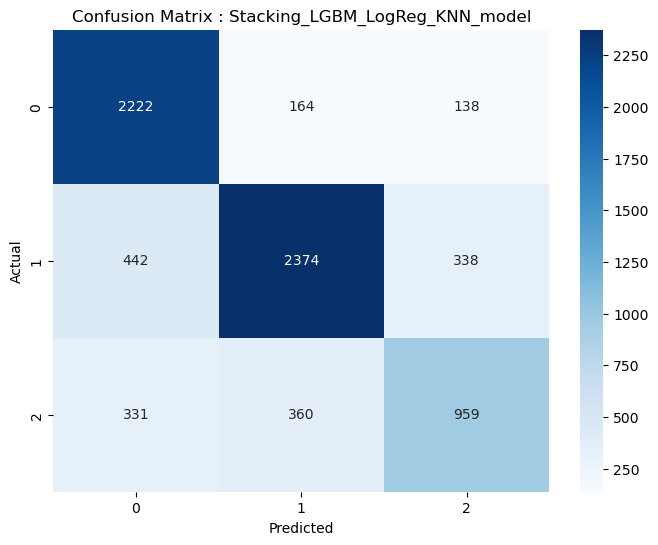

In [34]:
# Step 12: Log stacking model
log_mlflow(
            "Stacking_LGBM_LogReg_KNN", 
            stacking_model, {
                                "base_1": "LightGBM",
                                "base_2": "LogisticRegression",
                                "meta_learner": "KNeighborsClassifier",
                                "cv": 5
                            }
           )